$$
\begin{split}
D_{kl}(P\|Q)&=?\\
P(x)&=\mathcal N(\mu_1,\sigma_1)+\mathcal N(\mu_2, \sigma_2)\\
Q(x)&=\mathcal N(\mu_q=?, \sigma_q=?)
\end{split}
$$

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

## $P(x)$

In [24]:
mu1, sigma1 = -5, 3
mu2, sigma2 = 10, 1

In [25]:
gaussian1 = torch.distributions.Normal(mu1, sigma1)
gaussian2 = torch.distributions.Normal(mu2, sigma2)

Text(0.5, 1.0, '$\\mu_2$=10,$\\sigma_2$=1')

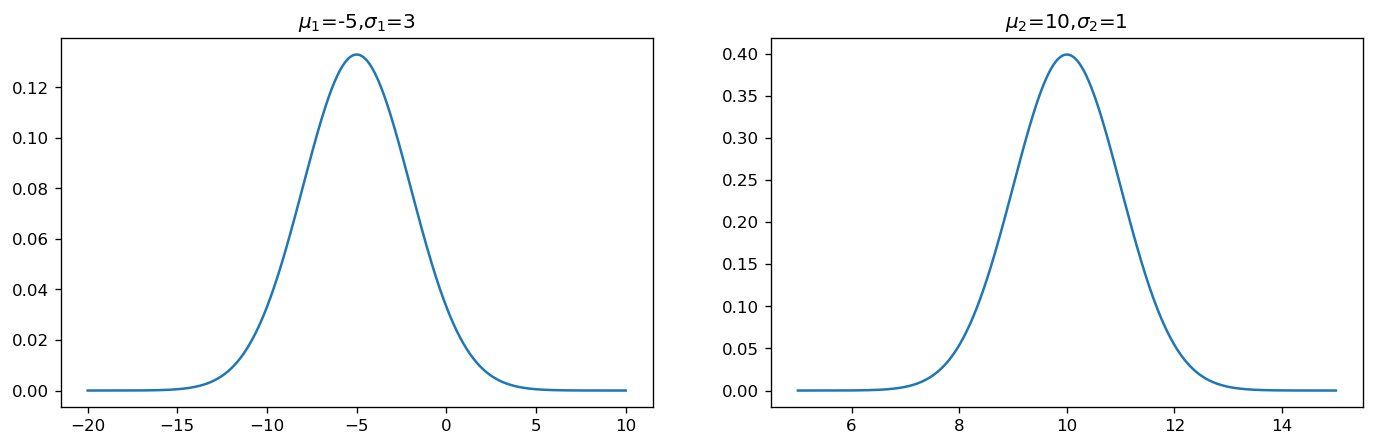

In [26]:
plt.figure(figsize=(14, 4))
x = torch.linspace(mu1-5*sigma1, mu1+5*sigma1, 1000)
plt.subplot(1, 2, 1)
plt.plot(x.numpy(), gaussian1.log_prob(x).exp().numpy())
plt.title(f'$\mu_1$={mu1},$\sigma_1$={sigma1}')

x = torch.linspace(mu2-5*sigma2, mu2+5*sigma2, 1000)
plt.subplot(1, 2, 2)
plt.plot(x.numpy(), gaussian2.log_prob(x).exp().numpy())
plt.title(f'$\mu_2$={mu2},$\sigma_2$={sigma2}')

Text(0.5, 1.0, '$P(X)$')

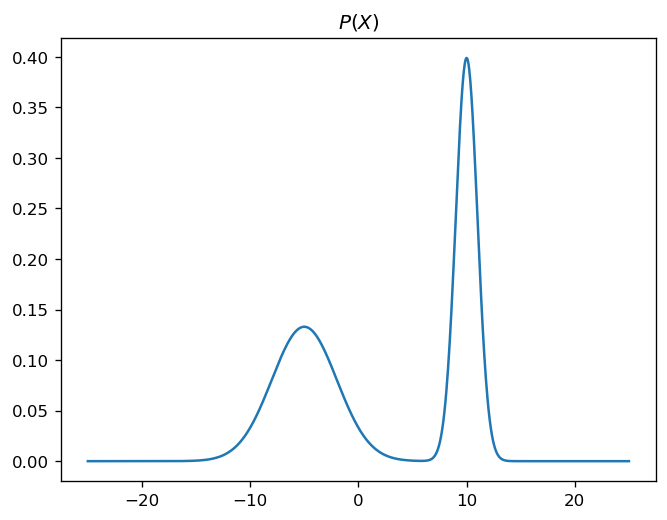

In [29]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
plt.plot(x.numpy(), px.numpy())
plt.title(f'$P(X)$')

## Q(x)

In [30]:
mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

Text(0.5, 1.0, '$Q(X)$')

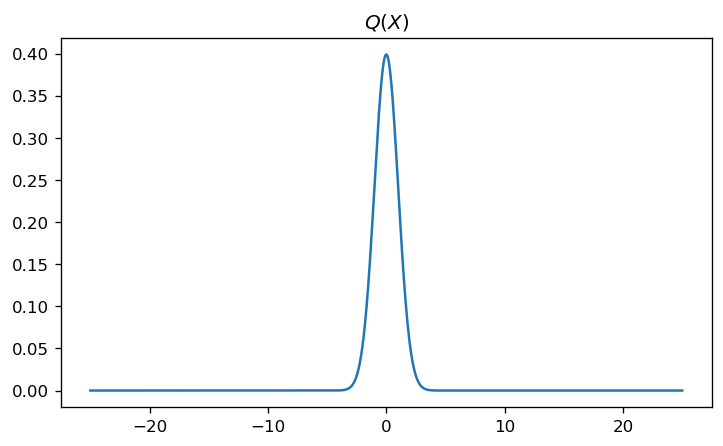

In [33]:
plt.figure(figsize=(7, 4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
Q = torch.distributions.Normal(mu, sigma) # this should approximate P, eventually :-)
qx = Q.log_prob(x).exp()
plt.plot(x.numpy(),qx.detach().numpy())
plt.title('$Q(X)$')

## kl-div

In [36]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,
                   mu1+mu2+5*sigma1+5*sigma2,
                   1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()

In [37]:
qx = Q.log_prob(x).exp()
F.kl_div(qx.log(), px)

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(inf)

In [38]:
qx = Q.log_prob(x)
F.kl_div(qx, px)

tensor(1.3067)

## kl-div as the loss

In [40]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,
                   mu1+mu2+5*sigma1+5*sigma2,
                   1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()

In [62]:
def optimize_loss(px, muq, sigmaq, ):
    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)
    opt = torch.optim.Adam([mu, sigma])
    
    all_mu = []
    all_sigma = []
    loss_val = []
    all_qx = []
    
    for i in range(10000):
        Q = torch.distributions.Normal(mu, sigma)
        qx = Q.log_prob(x)
        loss = F.kl_div(qx, px)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        all_qx.append(qx.exp().detach().numpy())
        
        if i % 1000 == 0:
            print(i, loss_val[-1])
            
    plt.subplot(1, 2, 1)
    plt.plot(loss_val)
    
    plt.subplot(1, 2, 2)
    plt.plot(all_mu)
    return mu.data.numpy()[0], sigma.data.numpy()[0], all_qx

0 1.3067318
1000 0.44491678
2000 0.2743505
3000 0.19724841
4000 0.15278623
5000 0.12406424
6000 0.10438409
7000 0.09049567
8000 0.08059149
9000 0.07355232


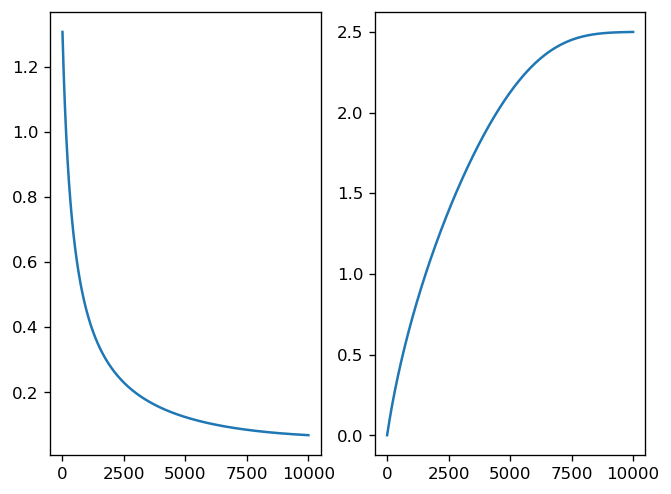

In [64]:
mu, sigma, all_qx = optimize_loss(px, 0., 1.)

In [55]:
len(all_qx)

10000